# Coursera Capstone Project

# Purple State Plunge: A Deep Dive into Pennsylvania's Cities

### By: Joseph J. Kamerdze III

First, import the required modules and census data

In [1]:
# Imports

import pandas as pd
import numpy as np
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

# Next, load the census file
path = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2018/cities/totals/sub-est2018_42.csv'

#import a table of all PA cities and their coordinates   
path3 = 'https://github.com/joek1479/github-example/raw/master/PAcity_coordinates.xlsx'

df=pd.read_csv(path)
print("~ Census data downloaded ~")
PAcoord=pd.read_excel(path3)
print("~ Coordinate data downloaded ~")

~ Census data downloaded ~
~ Coordinate data downloaded ~


Next, clean the data

In [2]:
# Remove unnecessary columns
df.drop(['SUMLEV', 'STATE','COUNTY','PLACE', 'COUSUB', 'CONCIT', 'PRIMGEO_FLAG', 'FUNCSTAT','STNAME','CENSUS2010POP',
         'ESTIMATEBASE2010'],
        inplace=True, axis=1, errors='ignore')
#sort by NAME field
df.sort_values("NAME",inplace=True)
#remove duplicate entries
df.drop_duplicates(subset=['NAME'],keep='first',inplace=True)

Create a dataframe that contains overall PA state info only

In [3]:
#dataframe for PA only
Statedata=df[df['NAME']=="Pennsylvania"][:]

Create columns for 10-year and 2-year growth rate

In [4]:
#growth % for entire state
PAgrowth10=[(Statedata['POPESTIMATE2018'][0]-Statedata['POPESTIMATE2010'][0])/(Statedata['POPESTIMATE2010'][0])*100]
PAgrowth2=[(Statedata['POPESTIMATE2018'][0]-Statedata['POPESTIMATE2016'][0])/(Statedata['POPESTIMATE2016'][0])*100]
PAgrowth10=PAgrowth10[0]
PAgrowth2=PAgrowth2[0]

Pull all cities out of the list and create a City dataframe

In [5]:
#create a dataframe of cities only
dfCity=df[df['NAME'].str.contains("city")][:]

Create columns for yearly growth rates

In [6]:
#create a column of population difference from 2010 to 2018
dfCity['PopDiff_10yr']=dfCity['POPESTIMATE2018']-dfCity['POPESTIMATE2010']
#create a column of % population growth from 2010 to 2018
dfCity['PopDiff%_10yr']=dfCity['PopDiff_10yr']/dfCity['POPESTIMATE2010']*100
#create a column of population difference from 2016 to 2018
dfCity['PopDiff_2yr']=dfCity['POPESTIMATE2018']-dfCity['POPESTIMATE2016']
#create a column of % population growth from 2016 to 2018
dfCity['PopDiff%_2yr']=dfCity['PopDiff_2yr']/dfCity['POPESTIMATE2016']*100
#create columns for yearly growth
dfCity['10-11growth%']=((dfCity['POPESTIMATE2011']-dfCity['POPESTIMATE2010'])/(dfCity['POPESTIMATE2010']))*100
dfCity['11-12growth%']=((dfCity['POPESTIMATE2012']-dfCity['POPESTIMATE2011'])/(dfCity['POPESTIMATE2011']))*100
dfCity['12-13growth%']=((dfCity['POPESTIMATE2013']-dfCity['POPESTIMATE2012'])/(dfCity['POPESTIMATE2012']))*100
dfCity['13-14growth%']=((dfCity['POPESTIMATE2014']-dfCity['POPESTIMATE2013'])/(dfCity['POPESTIMATE2013']))*100
dfCity['14-15growth%']=((dfCity['POPESTIMATE2015']-dfCity['POPESTIMATE2014'])/(dfCity['POPESTIMATE2014']))*100
dfCity['15-16growth%']=((dfCity['POPESTIMATE2016']-dfCity['POPESTIMATE2015'])/(dfCity['POPESTIMATE2015']))*100
dfCity['16-17growth%']=((dfCity['POPESTIMATE2017']-dfCity['POPESTIMATE2016'])/(dfCity['POPESTIMATE2016']))*100
dfCity['17-18growth%']=((dfCity['POPESTIMATE2018']-dfCity['POPESTIMATE2017'])/(dfCity['POPESTIMATE2017']))*100
#create a column of average year-to-year growth percentage
dfCity['AvgYrGrowth%']=(dfCity['10-11growth%']+dfCity['11-12growth%']+dfCity['12-13growth%']+dfCity['13-14growth%']+
                        dfCity['14-15growth%']+dfCity['15-16growth%']+dfCity['16-17growth%']+dfCity['17-18growth%'])/8
#sort values by PopDiff%_10yr field
dfCity.sort_values("PopDiff%_10yr",inplace=True,ascending=False)
dfCity.reset_index(drop=True,inplace=True)

Add coordinate data to the city population dataframe

In [7]:
#merge the city population dataframe with the coordinates table
dfCity=dfCity.merge(PAcoord,on='NAME')

### Map of Pennsylvania showing city locations

In [8]:
world_map = folium.Map()
PAlat=41.2033
PAlon=-77.1945
PA_map = folium.Map(location=[PAlat, PAlon], zoom_start=7.25,tiles='OpenStreetMap')

# create a feature group for the cities in the dataframe
cities = folium.map.FeatureGroup()

# loop through the cities and add each to the cities feature group
for lat, lng, in zip(dfCity.Latitude, dfCity.Longitude):
    cities.add_child(
        folium.features.CircleMarker([lat, lng],radius=5,color='blue',fill=True,fill_color='red',fill_opacity=0.6))

# add cities to map
PA_map.add_child(cities)

### Create Histograms of PA City Populations

First, let's see a histogram of city growth from 2010-2018 in relation to the state as a whole

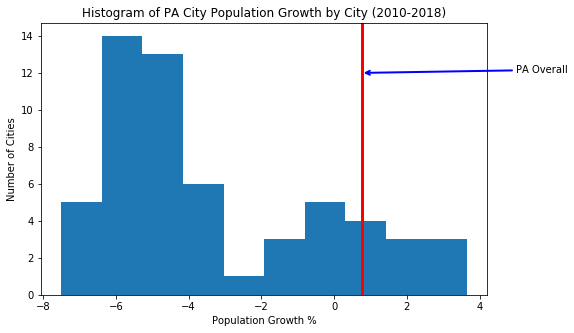

In [9]:
#create histogram of 10 year city growth
dfCity['PopDiff%_10yr'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of PA City Population Growth by City (2010-2018)')
plt.ylabel('Number of Cities')
plt.xlabel('Population Growth %')

goal=plt.axvline(x=PAgrowth10,linewidth=3, color='red')

# Annotate arrow
plt.annotate('PA Overall',
             xy=(PAgrowth10,12),             # head of the arrow
             xytext=(5,12),         # base of the arrow
             xycoords='data',         # will use the coordinate system of the object being annotated 
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2)
            )

plt.show()

Out of curiosity, what are the names of the cities on the right side of the red line?

In [10]:
#Which are the cities that have grown faster than the state over the past 10 years?
BoomCity10_index=dfCity[dfCity['PopDiff%_10yr']>PAgrowth10].index
BoomCity10=dfCity[dfCity['PopDiff%_10yr']>PAgrowth10]
BoomCity10['NAME']

0       Philadelphia city
1          Allentown city
2    Bethlehem city (pt.)
3            Lebanon city
4             Easton city
5           Scranton city
6          Bethlehem city
Name: NAME, dtype: object

Map Showing Cities that grew faster than the state from 2010-2018

In [11]:
world_map = folium.Map()
PAlat=41.2033
PAlon=-77.1945
PA_map2 = folium.Map(location=[PAlat, PAlon], zoom_start=7.25,tiles='OpenStreetMap')

# create a feature group for the cities in the dataframe
cities2 = folium.map.FeatureGroup()

# loop through the cities and add each to the cities feature group
for lat, lng, in zip(BoomCity10.Latitude, BoomCity10.Longitude):
    cities2.add_child(
        folium.features.CircleMarker([lat, lng],radius=5,color='blue',fill=True,fill_color='red',fill_opacity=0.6))

# add cities to map
PA_map2.add_child(cities2)

It looks like there are only 6 out of 57 cities that grew faster than the state as a whole.

Now, let's see a histogram of city growth from 2010-2018 in relation to the state as a whole.

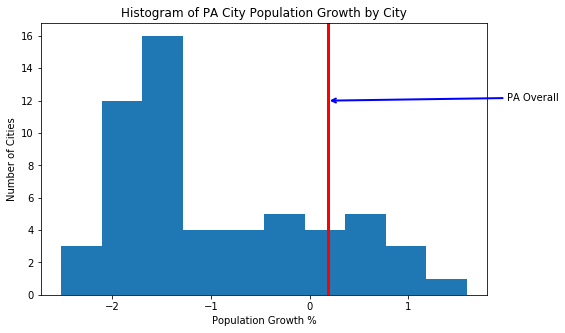

In [12]:
#create histogram of 2 year city growth
dfCity['PopDiff%_2yr'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of PA City Population Growth by City')
plt.ylabel('Number of Cities')
plt.xlabel('Population Growth %')

goal=plt.axvline(x=PAgrowth2,linewidth=3, color='red')

# Annotate arrow
plt.annotate('PA Overall',
             xy=(PAgrowth2,12),             # head of the arrow
             xytext=(2,12),         # base of the arrow
             xycoords='data',         # will use the coordinate system of the object being annotated 
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2)
            )

plt.show()

Out of curiosity, what are the names of the cities on the right side of the red line?

In [13]:
#Which are the cities that have grown faster than the state over the past 2 years?
BoomCity2_index=dfCity[dfCity['PopDiff%_2yr']>PAgrowth2].index
BoomCity2=dfCity[dfCity['PopDiff%_2yr']>PAgrowth2]
BoomCity2['NAME']

0        Philadelphia city
1           Allentown city
2     Bethlehem city (pt.)
3             Lebanon city
4              Easton city
6           Bethlehem city
8             Reading city
9            Pittston city
13           Duquesne city
15          Nanticoke city
Name: NAME, dtype: object

Map Showing Cities that grew faster than the state from 2016-2018

In [14]:
world_map = folium.Map()
PAlat=41.2033
PAlon=-77.1945
PA_map3 = folium.Map(location=[PAlat, PAlon], zoom_start=7.25,tiles='OpenStreetMap')

# create a feature group for the cities in the dataframe
cities3 = folium.map.FeatureGroup()

# loop through the cities and add each to the cities feature group
for lat, lng, in zip(BoomCity2.Latitude, BoomCity2.Longitude):
    cities3.add_child(
        folium.features.CircleMarker([lat, lng],radius=5,color='red',fill=True,fill_color='blue',fill_opacity=0.6))

# add cities to map
PA_map3.add_child(cities3)

It looks like 10 cities have grown faster than the overall state in the past 2 years. It looks like city growth has picked up.

### Find if any cities that have receded in the past 10 years are experiencing any growth in the last 2 years

In [15]:
#find all cities that have had negative growth over the past 10 years
Shrinking_Cities_index=dfCity[dfCity['PopDiff%_10yr']<0].index
Shrinking_Cities=dfCity[dfCity['PopDiff%_10yr']<0]

In [16]:
#of those shrinking cities, have any experienced growth in the past 2 years?
HopefulCities_index=Shrinking_Cities[Shrinking_Cities['PopDiff%_2yr']>0].index
HopefulCities=Shrinking_Cities[Shrinking_Cities['PopDiff%_2yr']>0][:]

In [17]:
HopefulCities['NAME']

13        Duquesne city
14      Harrisburg city
15       Nanticoke city
17    Wilkes-Barre city
Name: NAME, dtype: object

There are 4 total cities that have been on the decline, but are experiencing an upturn in population growth. There are our "Hopeful Cities."

### Find if any cities that have grown in the past 10 years are experiencing a decline in the last 2 years

In [18]:
#find all cities that have had positive growth over the past 10 years
Growing_Cities_index=dfCity[dfCity['PopDiff%_10yr']>0].index
Growing_Cities=dfCity[dfCity['PopDiff%_10yr']>0]

In [19]:
#of those growing cities, have any experienced a decline in the past 2 years?
SlowingCities_index=Growing_Cities[Growing_Cities['PopDiff%_2yr']<0].index
SlowingCities=Growing_Cities[Growing_Cities['PopDiff%_2yr']<0][:]

In [20]:
SlowingCities['NAME']

5        Scranton city
10    Coatesville city
11      Lancaster city
Name: NAME, dtype: object

There are 3 total cities that had been growing, but are experiencing an downturn in population growth. There are our "Slowing Cities."

Let's see what the Hopeful Cities look like on the map...

### Map Showing hopeful cities

In [21]:
world_map = folium.Map()
PAlat=41.2033
PAlon=-77.1945
PA_map4 = folium.Map(location=[PAlat, PAlon], zoom_start=7.25,tiles='OpenStreetMap')

# create a feature group for the cities in the dataframe
cities4 = folium.map.FeatureGroup()

# loop through the cities and add each to the cities feature group
for lat, lng, in zip(HopefulCities.Latitude, HopefulCities.Longitude):
    cities4.add_child(
        folium.features.CircleMarker([lat, lng],radius=5,color='blue',fill=True,fill_color='green',fill_opacity=0.8))

# add cities to map
PA_map4.add_child(cities4)

Now, let's see what the Slowing Cities look like on the map...

### Map Showing possibly declining cities

In [22]:
world_map = folium.Map()
PAlat=41.2033
PAlon=-77.1945
PA_map5 = folium.Map(location=[PAlat, PAlon], zoom_start=7.25,tiles='OpenStreetMap')

# create a feature group for the cities in the dataframe
cities5 = folium.map.FeatureGroup()

# loop through the cities and add each to the cities feature group
for lat, lng, in zip(SlowingCities.Latitude, SlowingCities.Longitude):
    cities5.add_child(
        folium.features.CircleMarker([lat, lng],radius=5,color='blue',fill=True,fill_color='red',fill_opacity=0.8))

# add cities to map
PA_map5.add_child(cities5)

### Apply Foursquare API

Use Foursquare to find out the top 10 venues for each of the 57 cities

In [23]:
CLIENT_ID = 'XXPL4UOBOTDQPYZZ2SHFCTTVQGSIY0W0B0J5EKRDGQKNP5UM' # Foursquare ID
CLIENT_SECRET = 'MKWUN4B4KQIGHTZG10NOLFYGLOSHRA3F4C2BNC5J2QQHWGRV' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [24]:
city_latitude = dfCity.loc[0, 'Latitude']
city_longitude = dfCity.loc[0, 'Longitude']
city_name = dfCity.loc[0, 'NAME']

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 8000 # define radius (8000m = approx 5 miles)

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    city_latitude, 
    city_longitude, 
    radius, 
    LIMIT)

In [25]:
results = requests.get(url).json()

In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [27]:
#clean the json and structure into a pandas df
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [28]:
#function to extract nearby venues from all cities
def getNearbyVenues(names, latitudes, longitudes, radius=8000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
# run the function on each PA city

PAcity_venues = getNearbyVenues(names=dfCity['NAME'],
                                   latitudes=dfCity['Latitude'],
                                   longitudes=dfCity['Longitude'])

Philadelphia city
Allentown city
Bethlehem city (pt.)
Lebanon city
Easton city
Scranton city
Bethlehem city
York city
Reading city
Pittston city
Coatesville city
Lancaster city
Chester city
Duquesne city
Harrisburg city
Nanticoke city
Pittsburgh city
Wilkes-Barre city
Hazleton city
McKeesport city
Clairton city
Washington city
Williamsport city
Monongahela city
Parker city
Connellsville city
Greensburg city
DuBois city
Sunbury city
Uniontown city
Meadville city
Corry city
Altoona city
Carbondale city
Lower Burrell city
Shamokin city
Erie city
St. Marys city
Pottsville city
Hermitage city
Jeannette city
Butler city
Arnold city
Aliquippa city
Monessen city
New Kensington city
Bradford city
Warren city
New Castle city
Farrell city
Titusville city
Sharon city
Lock Haven city
Beaver Falls city
Franklin city
Johnstown city
Oil City city


In [30]:
PAcity_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Aliquippa city,100,100,100,100,100,100
Allentown city,100,100,100,100,100,100
Altoona city,100,100,100,100,100,100
Arnold city,74,74,74,74,74,74
Beaver Falls city,100,100,100,100,100,100
Bethlehem city,100,100,100,100,100,100
Bethlehem city (pt.),100,100,100,100,100,100
Bradford city,46,46,46,46,46,46
Butler city,100,100,100,100,100,100


In [31]:
#analyze each city

# one hot encoding
PAcity_onehot = pd.get_dummies(PAcity_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
PAcity_onehot['City'] = PAcity_venues['City'] 

# move city column to the first column
fixed_columns = [PAcity_onehot.columns[-1]] + list(PAcity_onehot.columns[:-1])
PAcity_onehot = PAcity_onehot[fixed_columns]
#PAcity_onehot.head()

In [32]:
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
PAcity_grouped = PAcity_onehot.groupby('City').mean().reset_index()
#PAcity_grouped

In [33]:
num_top_venues = 5

for City in PAcity_grouped['City']:
    print("----"+City+"----")
    temp = PAcity_grouped[PAcity_grouped['City'] == City].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aliquippa city----
                  venue  freq
0        Discount Store  0.10
1  Fast Food Restaurant  0.09
2                   Bar  0.06
3        Sandwich Place  0.06
4           Pizza Place  0.05


----Allentown city----
                venue  freq
0      Ice Cream Shop  0.06
1  Italian Restaurant  0.04
2      Clothing Store  0.04
3                Park  0.04
4         Pizza Place  0.04


----Altoona city----
                venue  freq
0         Gas Station  0.08
1  Italian Restaurant  0.06
2                 Bar  0.05
3  Mexican Restaurant  0.04
4      Sandwich Place  0.04


----Arnold city----
                  venue  freq
0        Discount Store  0.12
1   American Restaurant  0.09
2        Sandwich Place  0.05
3  Fast Food Restaurant  0.05
4    Italian Restaurant  0.04


----Beaver Falls city----
                 venue  freq
0                  Bar  0.08
1  American Restaurant  0.08
2       Ice Cream Shop  0.04
3        Hot Dog Joint  0.04
4          Pizza Place  0.04


----Bet

                 venue  freq
0                Hotel  0.05
1                  Bar  0.05
2       Sandwich Place  0.04
3  American Restaurant  0.04
4          Coffee Shop  0.04


----Pittston city----
                venue  freq
0         Pizza Place  0.12
1  Italian Restaurant  0.11
2                 Bar  0.08
3      Ice Cream Shop  0.05
4          Donut Shop  0.05


----Pottsville city----
                 venue  freq
0          Pizza Place  0.08
1        Grocery Store  0.08
2             Pharmacy  0.06
3  American Restaurant  0.06
4       Discount Store  0.06


----Reading city----
                 venue  freq
0                  Bar  0.09
1   Mexican Restaurant  0.08
2          Pizza Place  0.05
3       Sandwich Place  0.04
4  American Restaurant  0.04


----Scranton city----
                 venue  freq
0   Italian Restaurant  0.08
1          Pizza Place  0.08
2                  Bar  0.08
3               Bakery  0.04
4  American Restaurant  0.04


----Shamokin city----
               

In [34]:
#write a function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now, let's get the top 10 venues for each city

In [35]:
#df to display the top 10 venues for each city
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
PAcity_venues_sorted = pd.DataFrame(columns=columns)
PAcity_venues_sorted['City'] = PAcity_grouped['City']

for ind in np.arange(PAcity_grouped.shape[0]):
    PAcity_venues_sorted.iloc[ind, 1:] = return_most_common_venues(PAcity_grouped.iloc[ind, :], num_top_venues)

Rename the first column in Hopeful Cities and Slowing Cities so they can be merged with the Foursquare data

In [36]:
HopefulCities.rename(columns={'NAME' : 'City'},inplace=True)
HopefulCities=HopefulCities.merge(PAcity_venues_sorted,on='City')
SlowingCities.rename(columns={'NAME' : 'City'},inplace=True)
SlowingCities=SlowingCities.merge(PAcity_venues_sorted,on='City')

### Clustering

Now, let's cluster the cities based on their most common venues

In [37]:
# set number of clusters
kclusters = 5

PAcity_grouped_clustering = PAcity_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(PAcity_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

In [38]:
# add clustering labels
PAcity_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

PAcity_merged = dfCity[:]

PAcity_merged.rename(columns={'NAME' : 'City'},inplace=True)

# merge PAcity_grouped with PAcity_data to add latitude/longitude for each city
PAcity_merged = PAcity_merged.join(PAcity_venues_sorted.set_index('City'), on='City')

Let's map the clusters!

In [39]:
# create clustered map
map_clusters = folium.Map(location=[PAlat, PAlon], zoom_start=7.25)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(PAcity_merged['Latitude'], PAcity_merged['Longitude'], PAcity_merged['City'], PAcity_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, let's explore each cluster

### Cluster 1 (Red) - Big Cities

We can refer to this cluster as "Big Cities" since it contains most of the state's largest cities

In [40]:
PAcity_merged.loc[PAcity_merged['Cluster Labels'] == 0, PAcity_merged.columns[[0] + list(range(5, PAcity_merged.shape[1]))]]

,City,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,PopDiff_10yr,PopDiff%_10yr,PopDiff_2yr,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Philadelphia city,1558371,1565604,1571258,1576390,1580221,1584138,55845,3.654077,7748,...,Coffee Shop,Pizza Place,New American Restaurant,Indian Restaurant,American Restaurant,Steakhouse,Wine Bar,Hotel,Italian Restaurant,Bar
1,Allentown city,118832,119181,120068,120371,120966,121433,3319,2.809997,1062,...,Ice Cream Shop,Italian Restaurant,Clothing Store,American Restaurant,Pizza Place,Park,Bakery,Farmers Market,Bar,Convenience Store
2,Bethlehem city (pt.),19533,19632,19645,19696,19794,19869,522,2.698093,173,...,American Restaurant,Italian Restaurant,Salon / Barbershop,Mexican Restaurant,Convenience Store,Park,Café,Pizza Place,Ice Cream Shop,Supermarket
4,Easton city,27080,27065,27012,27051,27142,27216,410,1.529508,165,...,Pizza Place,Italian Restaurant,Coffee Shop,American Restaurant,Sandwich Place,Ice Cream Shop,Golf Course,Mexican Restaurant,Bakery,Hot Dog Joint
6,Bethlehem city,74836,74955,74953,75255,75545,75790,834,1.112653,535,...,American Restaurant,Italian Restaurant,Salon / Barbershop,Mexican Restaurant,Convenience Store,Park,Café,Pizza Place,Ice Cream Shop,Supermarket
8,Reading city,88295,88204,88083,88145,88158,88495,431,0.489417,350,...,Bar,Mexican Restaurant,Pizza Place,American Restaurant,Sandwich Place,Italian Restaurant,Ice Cream Shop,Coffee Shop,Farmers Market,Fast Food Restaurant
11,Lancaster city,59468,59483,59508,59546,59532,59420,73,0.123005,-126,...,Coffee Shop,American Restaurant,Brewery,Café,Park,Bar,Asian Restaurant,Italian Restaurant,Hotel,Grocery Store
14,Harrisburg city,49365,49333,49248,49172,49208,49229,-275,-0.555511,57,...,Pizza Place,American Restaurant,Park,Italian Restaurant,Coffee Shop,Café,Sandwich Place,Bar,Farmers Market,Brewery
16,Pittsburgh city,307022,306092,304211,304814,301720,301048,-4362,-1.428244,-3766,...,Hotel,Bar,American Restaurant,Sandwich Place,Coffee Shop,Mexican Restaurant,Scenic Lookout,Bakery,Thai Restaurant,Pizza Place
17,Wilkes-Barre city,41024,41025,40877,40762,40880,40806,-681,-1.641478,44,...,Bar,Pizza Place,American Restaurant,Deli / Bodega,Hot Dog Joint,Steakhouse,Mexican Restaurant,Department Store,Coffee Shop,Sandwich Place


### Cluster 2 (Purple) - Western PA, Small cities

These cities are all located on the western half of the state, and most have a population of 20,000 or less

In [41]:
PAcity_merged.loc[PAcity_merged['Cluster Labels'] == 1, PAcity_merged.columns[[0] + list(range(5, PAcity_merged.shape[1]))]]

,City,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,PopDiff_10yr,PopDiff%_10yr,PopDiff_2yr,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,McKeesport city,19711,19636,19494,19358,19215,19115,-615,-3.117081,-243,...,Discount Store,Fast Food Restaurant,Theme Park Ride / Attraction,Italian Restaurant,Bar,Grocery Store,Ice Cream Shop,Pharmacy,Sandwich Place,Brewery
27,DuBois city,7668,7621,7588,7521,7461,7415,-364,-4.679265,-106,...,American Restaurant,Fast Food Restaurant,Hotel,Gas Station,Discount Store,Pizza Place,Grocery Store,Sandwich Place,Italian Restaurant,Bar
29,Uniontown city,10124,10052,9971,9899,9802,9835,-500,-4.837929,-64,...,Discount Store,Fast Food Restaurant,American Restaurant,Italian Restaurant,Bar,Clothing Store,Sandwich Place,Cosmetics Shop,Department Store,Pizza Place
30,Meadville city,13283,13161,12999,13003,12838,12721,-648,-4.847034,-282,...,American Restaurant,Fast Food Restaurant,Pizza Place,Bar,Discount Store,Video Store,Gas Station,Pharmacy,Mobile Phone Shop,Pub
39,Hermitage city,16150,16081,15956,15805,15671,15535,-886,-5.395530,-270,...,Discount Store,American Restaurant,Fast Food Restaurant,Bar,Ice Cream Shop,Sandwich Place,Wings Joint,Pharmacy,Gas Station,Mexican Restaurant
41,Butler city,13554,13380,13293,13172,13101,12993,-761,-5.532936,-179,...,Discount Store,American Restaurant,Sandwich Place,Fast Food Restaurant,Clothing Store,Chinese Restaurant,Pizza Place,Cosmetics Shop,Bakery,Bar
49,Farrell city,4854,4824,4778,4730,4686,4640,-307,-6.205781,-90,...,Discount Store,Fast Food Restaurant,Sandwich Place,American Restaurant,Bar,Ice Cream Shop,Donut Shop,Mexican Restaurant,Gas Station,Wings Joint
51,Sharon city,13721,13631,13503,13368,13239,13109,-890,-6.357597,-259,...,Discount Store,Sandwich Place,American Restaurant,Fast Food Restaurant,Ice Cream Shop,Bar,Wings Joint,Pharmacy,Gas Station,Mexican Restaurant
53,Beaver Falls city,8806,8712,8665,8556,8448,8387,-608,-6.759311,-169,...,American Restaurant,Bar,Ice Cream Shop,Discount Store,Hot Dog Joint,Sandwich Place,Pizza Place,Fast Food Restaurant,Café,Park
55,Johnstown city,20422,20213,19992,19766,19675,19447,-1513,-7.218511,-319,...,Bar,Discount Store,Sandwich Place,Gas Station,American Restaurant,Fast Food Restaurant,Pizza Place,Supermarket,Café,Grocery Store


### Cluster 3 (Blue) - "Purple State PA", representative sampling

This cluster could be referred to as representative of the entire state. The cities are dispersed across the entire state with a wide range of populations.
Note: The phrase "Purple State" refers to a state's political leanings. Pennsylvania is classified as a "swing state" in presidential elections because it swings between voting conservative (red) and liberal (blue), hence the combination of red and blue = purple. The phrase is being used here to describe the combination of east-west coasts and high-low populations, as well as growing-shrinking populations

In [42]:
PAcity_merged.loc[PAcity_merged['Cluster Labels'] == 2, PAcity_merged.columns[[0] + list(range(5, PAcity_merged.shape[1]))]]

,City,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,PopDiff_10yr,PopDiff%_10yr,PopDiff_2yr,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Lebanon city,25610,25652,25689,25721,25731,25902,448,1.760038,181,...,American Restaurant,Fast Food Restaurant,Pizza Place,Golf Course,Pharmacy,Sandwich Place,Grocery Store,Cosmetics Shop,Restaurant,Chinese Restaurant
5,Scranton city,75838,75449,77160,77264,77282,77182,1097,1.441809,-82,...,Italian Restaurant,Pizza Place,Bar,American Restaurant,Bakery,Ice Cream Shop,Mexican Restaurant,Donut Shop,Sushi Restaurant,Deli / Bodega
7,York city,44025,43967,44049,44060,44068,44118,256,0.583649,58,...,Pizza Place,Bar,Fast Food Restaurant,American Restaurant,Coffee Shop,Sandwich Place,Brewery,Mexican Restaurant,Bakery,Gym
9,Pittston city,7671,7704,7666,7633,7700,7755,25,0.323415,122,...,Pizza Place,Italian Restaurant,Bar,Discount Store,Ice Cream Shop,Donut Shop,Pharmacy,Grocery Store,Diner,Gas Station
10,Coatesville city,13155,13191,13169,13129,13114,13114,29,0.221628,-15,...,Pizza Place,Italian Restaurant,Diner,Convenience Store,Golf Course,Chinese Restaurant,Bar,Discount Store,Restaurant,Donut Shop
12,Chester city,34054,34063,34012,33973,33906,33909,-31,-0.091338,-64,...,Convenience Store,Pizza Place,Grocery Store,American Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Fast Food Restaurant,Bar,Bakery
13,Duquesne city,5561,5539,5542,5535,5535,5548,-18,-0.323392,13,...,Bar,Theme Park Ride / Attraction,Pizza Place,Italian Restaurant,Fast Food Restaurant,Brewery,Sandwich Place,Restaurant,Coffee Shop,Grocery Store
22,Williamsport city,29295,29193,29018,28727,28474,28348,-1048,-3.565111,-379,...,American Restaurant,Pizza Place,Discount Store,Sandwich Place,Gas Station,Italian Restaurant,Bar,Pharmacy,Brewery,Fast Food Restaurant
26,Greensburg city,14658,14563,14458,14405,14287,14192,-692,-4.649288,-213,...,Pizza Place,American Restaurant,Bar,Italian Restaurant,Fast Food Restaurant,Grocery Store,Hotel,Donut Shop,Park,Coffee Shop
28,Sunbury city,9761,9716,9637,9563,9495,9409,-472,-4.776844,-154,...,Pizza Place,Discount Store,Mexican Restaurant,American Restaurant,Steakhouse,Pharmacy,Ice Cream Shop,Cosmetics Shop,Fast Food Restaurant,Grocery Store


### Cluster 4 (Green) - Small, skrinking cities

12 out of the 20 cities in this cluster have populations of less than 10,000 people, and all of these cities have experienced negative growth between 2010 and 2018.

In [43]:
PAcity_merged.loc[PAcity_merged['Cluster Labels'] == 3, PAcity_merged.columns[[0] + list(range(5, PAcity_merged.shape[1]))]]

,City,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,PopDiff_10yr,PopDiff%_10yr,PopDiff_2yr,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Nanticoke city,10358,10325,10273,10229,10288,10334,-128,-1.223475,105,...,Pizza Place,Pharmacy,Discount Store,Bar,Sandwich Place,BBQ Joint,Supermarket,Bank,Ice Cream Shop,Gas Station
18,Hazleton city,25088,25003,24881,24769,24753,24703,-641,-2.529198,-66,...,Discount Store,Pizza Place,Sandwich Place,Italian Restaurant,Gas Station,Hotel,American Restaurant,Bar,Pharmacy,Mobile Phone Shop
20,Clairton city,6781,6755,6704,6655,6604,6566,-223,-3.284725,-89,...,Discount Store,Pharmacy,American Restaurant,Bank,Pizza Place,Italian Restaurant,Sandwich Place,Fast Food Restaurant,Golf Course,Trail
23,Monongahela city,4239,4216,4198,4162,4147,4131,-164,-3.818393,-31,...,Sandwich Place,Discount Store,Convenience Store,Italian Restaurant,Fast Food Restaurant,Gas Station,Bar,Water Park,BBQ Joint,Miscellaneous Shop
25,Connellsville city,7546,7517,7477,7431,7376,7316,-326,-4.265899,-115,...,Discount Store,Gas Station,Bank,American Restaurant,Grocery Store,Pizza Place,Fast Food Restaurant,Pub,Movie Theater,Big Box Store
31,Corry city,6556,6502,6462,6408,6345,6288,-321,-4.857013,-120,...,Fast Food Restaurant,Pizza Place,Discount Store,Pharmacy,Grocery Store,Restaurant,Coffee Shop,Department Store,Diner,Sandwich Place
35,Shamokin city,7268,7229,7163,7105,7050,6984,-379,-5.147358,-121,...,Discount Store,Fast Food Restaurant,Pizza Place,Grocery Store,Sandwich Place,Pharmacy,Bar,Gas Station,Food,Ice Cream Shop
37,St. Marys city,12877,12772,12643,12493,12407,12359,-673,-5.164211,-134,...,Fast Food Restaurant,Pizza Place,Gas Station,Discount Store,American Restaurant,Italian Restaurant,Sandwich Place,Bar,Forest,Bakery
38,Pottsville city,14060,13946,13825,13730,13629,13555,-763,-5.328957,-175,...,Pizza Place,Grocery Store,Pharmacy,American Restaurant,Fast Food Restaurant,Discount Store,Bar,Sandwich Place,Donut Shop,Gas Station
42,Arnold city,5060,5022,4984,4940,4897,4861,-288,-5.593319,-79,...,Discount Store,American Restaurant,Sandwich Place,Fast Food Restaurant,Grocery Store,Italian Restaurant,Bar,Bank,Convenience Store,Park


### Cluster 5 (Orange) - Parker City: The smallest city in the US

This cluster only contains one city - Parker City. This city is nationally known as the smallest city in the US. This city and resulting cluster could be referred to as an outlier due to its small population size.

In [44]:
PAcity_merged.loc[PAcity_merged['Cluster Labels'] == 4, PAcity_merged.columns[[0] + list(range(5, PAcity_merged.shape[1]))]]

,City,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,PopDiff_10yr,PopDiff%_10yr,PopDiff_2yr,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Parker city,843,837,827,822,815,808,-35,-4.151839,-14,...,Hotel,American Restaurant,Restaurant,Bowling Alley,Candy Store,Park,Grocery Store,Pizza Place,Cycle Studio,Eye Doctor


Cluster #1 Population Histogram

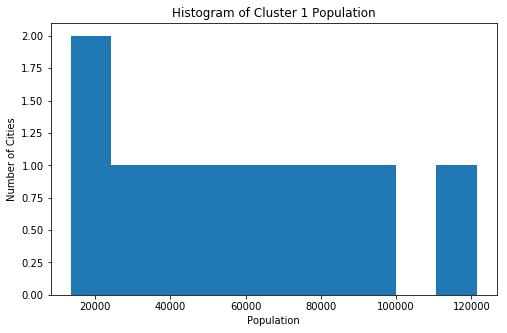

In [45]:
#create dataframe for cluster 1
C1_index=PAcity_merged[PAcity_merged['Cluster Labels'] == 0].index
C1=PAcity_merged[PAcity_merged['Cluster Labels'] == 0]
#drop Philadelphia and Pittsburgh from C1 histogram since they are so large
C1=C1[~C1.City.str.contains("Philadelphia city")]
C1=C1[~C1.City.str.contains("Pittsburgh city")]
#create histogram of Cluster 1 population
C1['POPESTIMATE2018'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Cluster 1 Population')
plt.ylabel('Number of Cities')
plt.xlabel('Population')

plt.show()

Cluster #1 population growth histogram

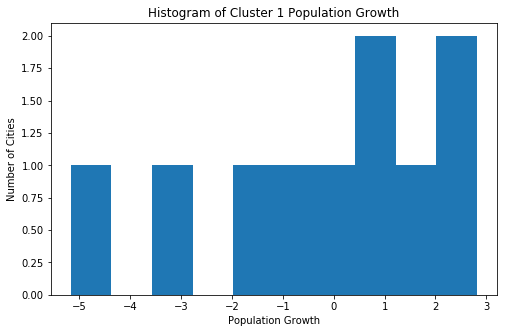

In [46]:
#create histogram of Cluster 1 population growth
C1['PopDiff%_10yr'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Cluster 1 Population Growth')
plt.ylabel('Number of Cities')
plt.xlabel('Population Growth')

plt.show()

Cluster #2 Population Histogram

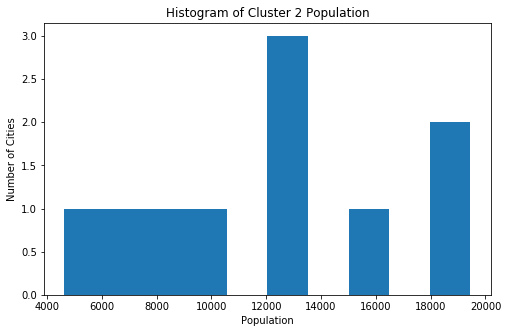

In [47]:
#create dataframe for cluster 2
C2_index=PAcity_merged[PAcity_merged['Cluster Labels'] == 1].index
C2=PAcity_merged[PAcity_merged['Cluster Labels'] == 1]

#create histogram of Cluster 2 population
C2['POPESTIMATE2018'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Cluster 2 Population')
plt.ylabel('Number of Cities')
plt.xlabel('Population')

plt.show()

Cluster #2 Population growth rate histogram

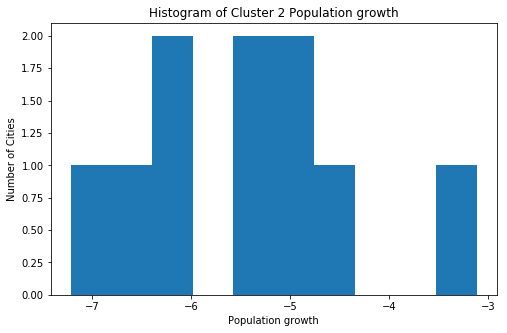

In [48]:
#create histogram of Cluster 2 population growth
C2['PopDiff%_10yr'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Cluster 2 Population growth')
plt.ylabel('Number of Cities')
plt.xlabel('Population growth')

plt.show()

Cluster #3 Population Histogram

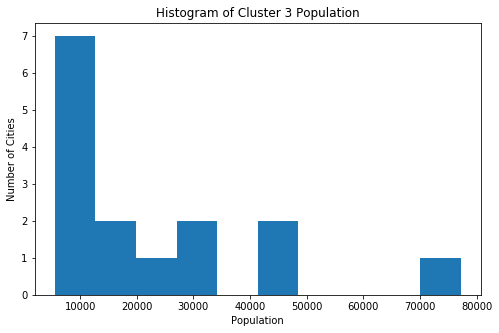

In [49]:
#create dataframe for cluster 3
C3_index=PAcity_merged[PAcity_merged['Cluster Labels'] == 2].index
C3=PAcity_merged[PAcity_merged['Cluster Labels'] == 2]

#create histogram of Cluster 3 population
C3['POPESTIMATE2018'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Cluster 3 Population')
plt.ylabel('Number of Cities')
plt.xlabel('Population')

plt.show()

Cluster #3 Population growth histogram

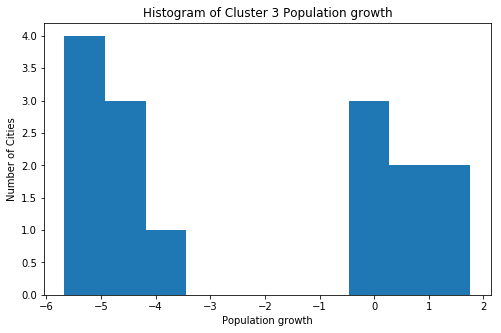

In [50]:
#create histogram of Cluster 3 population growth
C3['PopDiff%_10yr'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Cluster 3 Population growth')
plt.ylabel('Number of Cities')
plt.xlabel('Population growth')

plt.show()

Cluster #4 Population Histogram

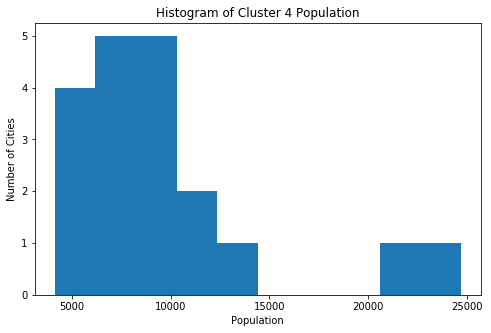

In [51]:
#create dataframe for cluster 4
C4_index=PAcity_merged[PAcity_merged['Cluster Labels'] == 3].index
C4=PAcity_merged[PAcity_merged['Cluster Labels'] == 3]

#create histogram of Cluster 4 population
C4['POPESTIMATE2018'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Cluster 4 Population')
plt.ylabel('Number of Cities')
plt.xlabel('Population')

plt.show()

Cluster #4 population growth rate histogram

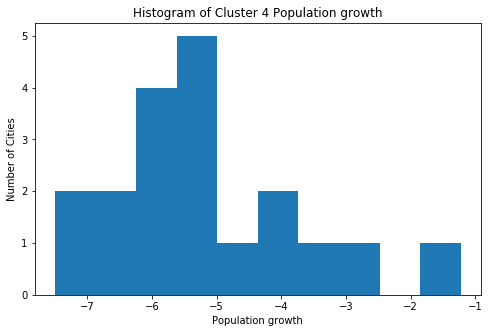

In [52]:
#create histogram of Cluster 4 population growth
C4['PopDiff%_10yr'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Cluster 4 Population growth')
plt.ylabel('Number of Cities')
plt.xlabel('Population growth')

plt.show()

# The End